In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [3]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset = load_diabetes()
print(diabetes_dataset["DESCR"])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [4]:
# Save the input and target variables

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

In [5]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0))/targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [6]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [7]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


def get_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    return model

model = get_model()

In [8]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 67,585
Trainable params: 67,585
Non-trainable params: 0
____________________________________________________

In [9]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [11]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100, validation_split=0.15, verbose=False)

In [12]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 1.1820 - mse: 1.0309


[1.0308735609054565, 1.0308737]

#### Plot the learning curves

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

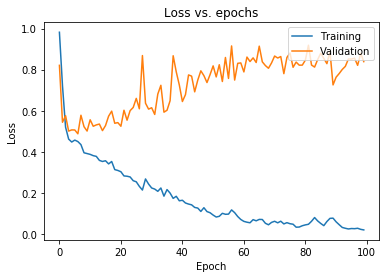

In [14]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [16]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l1_l2(wd, wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l1_l2(wd, wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l1_l2(wd, wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l1_l2(wd, wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l1_l2(wd, wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l1_l2(wd, wd), activation="relu"),
        Dense(1)
    ])
    return model

In [17]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])


In [19]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=100, validation_split=0.15, batch_size=64, verbose=1)


Train on 337 samples, validate on 60 samples
Epoch 1/100
337/337 [==============================] - 2s 6ms/sample - loss: 1.0895 - mse: 1.0192 - val_loss: 1.0097 - val_mse: 0.9399
Epoch 2/100
337/337 [==============================] - 0s 552us/sample - loss: 1.0736 - mse: 1.0040 - val_loss: 0.9810 - val_mse: 0.9119
Epoch 3/100
337/337 [==============================] - 0s 577us/sample - loss: 1.0177 - mse: 0.9488 - val_loss: 0.8643 - val_mse: 0.7958
Epoch 4/100
337/337 [==============================] - 0s 330us/sample - loss: 0.8745 - mse: 0.8062 - val_loss: 0.7191 - val_mse: 0.6510
Epoch 5/100
337/337 [==============================] - 0s 582us/sample - loss: 0.7280 - mse: 0.6600 - val_loss: 0.6559 - val_mse: 0.5882
Epoch 6/100
337/337 [==============================] - 0s 588us/sample - loss: 0.6856 - mse: 0.6180 - val_loss: 0.6484 - val_mse: 0.5810
Epoch 7/100
337/337 [==============================] - 0s 592us/sample - loss: 0.6452 - mse: 0.5780 - val_loss: 0.6845 - val_mse: 0.617

In [20]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=False)


[0.8170562505722045, 0.7638578]

#### Plot the learning curves

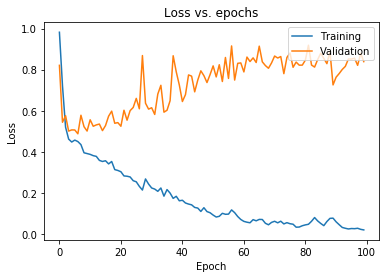

In [21]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [28]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback

class TrainingCallbacks(Callback):
    def on_train_begin(self, logs=None):
        print("Starting training...")
        
    def on_train_epoch_begin(self, epoch, logs=None):
        print("Training: Starting epoch {}".format(epoch))
    
    def on_train_batch_begin(self, batch, logs=None):
        print("Training: Starting betch {}".format(batch))
        
    def on_train_batch_end(self, batch, logs=None):
        print("Training: Ending batch {}".format(batch))

    def on_train_epoch_end(self, epoch, logs=None):
        print("Training: Ending epoch {}".format(epoch))
    
    def on_train_end(self, log=None):
        print("Finish training...")

# Contains no epoch
class TestingCallbacks(Callback):
    def on_test_begin(self, logs=None):
        print("Starting training...")
    
    def on_test_batch_begin(self, batch, logs=None):
        print("Training: Starting betch {}".format(batch))
        
    def on_test_batch_end(self, batch, logs=None):
        print("Training: Ending batch {}".format(batch))
    
    def on_test_end(self, log=None):
        print("Finish training...")

# Contains no epoch, no batch
class PredictionCallbacks(Callback):
    def on_predict_begin(self, logs=None):
        print("Starting training...")
    
    def on_predict_end(self, log=None):
        print("Finish training...")
    

In [29]:
# Re-build the model
model = get_regularised_model(1e-5, 0.3)

In [30]:
# Compile the model
model.compile(optimizer='adam', loss='mse')


#### Train the model with the callback

In [31]:
# Train the model, with some of the data reserved for validation
model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallbacks()])

Starting training...
Training: Starting betch 0
Training: Ending batch 0
Training: Starting betch 1
Training: Ending batch 1
Training: Starting betch 2
Training: Ending batch 2
Training: Starting betch 3
Training: Ending batch 3
Training: Starting betch 0
Training: Ending batch 0
Training: Starting betch 1
Training: Ending batch 1
Training: Starting betch 2
Training: Ending batch 2
Training: Starting betch 3
Training: Ending batch 3
Training: Starting betch 0
Training: Ending batch 0
Training: Starting betch 1
Training: Ending batch 1
Training: Starting betch 2
Training: Ending batch 2
Training: Starting betch 3
Training: Ending batch 3
Finish training...


In [32]:
# Evaluate the model
model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallbacks()])

Starting training...
Training: Starting betch 0
Training: Ending batch 0
Training: Starting betch 1
Training: Ending batch 1
Finish training...


0.9375426001018948

In [34]:
# Make predictions with the model
model.predict(test_data, verbose=False, callbacks=[PredictionCallbacks()])

Starting training...
Finish training...


array([[ 0.03226118],
       [-0.01420988],
       [ 0.04444126],
       [ 0.10073065],
       [ 0.02882545],
       [-0.06076197],
       [-0.04634317],
       [ 0.01654706],
       [-0.04457604],
       [ 0.05588304],
       [-0.01225823],
       [-0.02154528],
       [ 0.05919605],
       [ 0.08992133],
       [-0.04938813],
       [ 0.06457143],
       [-0.04551258],
       [-0.05519424],
       [ 0.0719762 ],
       [ 0.00103078],
       [ 0.05563036],
       [ 0.04692883],
       [ 0.07613321],
       [-0.04307739],
       [ 0.07259019],
       [-0.04029458],
       [-0.03352893],
       [-0.0461181 ],
       [-0.03389696],
       [ 0.07532933],
       [-0.04506593],
       [-0.04131549],
       [ 0.13017175],
       [ 0.10086494],
       [ 0.09093145],
       [ 0.02906269],
       [ 0.00516362],
       [ 0.11050185],
       [ 0.05113698],
       [ 0.05383497],
       [ 0.03225778],
       [ 0.01572988],
       [-0.03212334],
       [-0.05456719],
       [-0.00323803]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [27]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, train_targets, 
                                        epochs=100,
                                       validation_split=0.15,
                                       batch_size=64,
                                       verbose=False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [28]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=2)

45/1 - 0s - loss: 0.4890


0.5260577645566729

In [29]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-5, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data, train_targets,
                                           epochs=100,
                                           validation_split=0.15,
                                           batch_size=64,
                                           verbose=False,
                                           callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [30]:
# Evaluate the model on the test set
regularised_model.evaluate(test_data, test_targets, verbose=2)


45/1 - 0s - loss: 0.5776


0.5816100305981107

#### Plot the learning curves

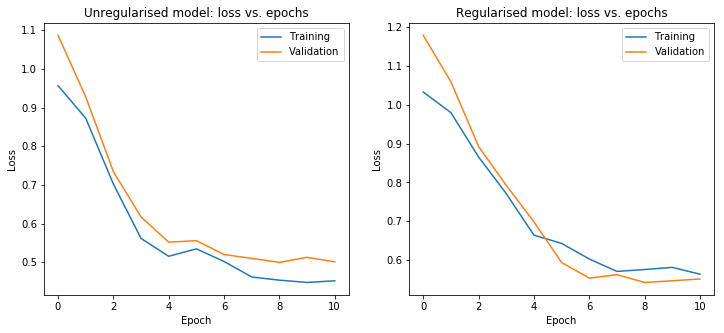

In [31]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()